# Maskinlæring

I denne notebooken har vi allerede skrevet Pythonkode og forklaringer for hvordan vi kan

- bruke de nyvaskede og utforskede dataene våre til å trene en modell for svindeldeteksjon.

- måle kvaliteten til modellene våre.

- _øke_ kvaliteten til modellene våre. 

- kontrollere hvordan modellene våre oppfører seg, basert på våre egne prioriteringer.

Dette er forutsetninger for å løse oppgaven på en god måte! Oppgaven kommer i bunnen av notebooken, og mye av koden i denne notebooken kan være nyttig å bruks i arbeidet med oppgaven.



Først leser vi inn dataen våre til en Pandas DataFrame.

Filen vi leser inn her skal ha blitt laget med den andre notebooken, hvor man utforsket og vasket dataene. Den skal være klar til bruk i maskinlæringsmodellen(e) dine. Hvis

In [1]:
import pandas as pd
df = pd.read_parquet('data/fraud_processed.pq')

For at koden i denne notebooken skal fungere må du ha konvertert alle kolonnene til numeriske typer (int, float). Hvis noen av disse er "object" eller "string" vil du fort møte problemer:

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11565 entries, 0 to 11564
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    11565 non-null  int64 
 1   Month                 11565 non-null  int64 
 2   WeekOfMonth           11565 non-null  int64 
 3   DayOfWeek             11565 non-null  object
 4   Make                  11565 non-null  object
 5   AccidentArea          11565 non-null  object
 6   DayOfWeekClaimed      11565 non-null  object
 7   MonthClaimed          11565 non-null  object
 8   WeekOfMonthClaimed    11565 non-null  int64 
 9   Sex                   11565 non-null  int64 
 10  MaritalStatus         11565 non-null  object
 11  Age                   11565 non-null  int64 
 12  Fault                 11565 non-null  object
 13  PolicyType            11565 non-null  object
 14  VehicleCategory       11565 non-null  object
 15  VehiclePrice          11565 non-null

Når man trener en maskinlæringsmodell er det viktig å sette tilside noe data som man ikke trener på, så man kan teste på den hvor mye den har lært under trening som generaliserer til data den ikke har sett før, som jo er tilfellet vi ønsker at den skal gjøre det bra på!

Her separerer vi `X` (modellens "input", "uavhengige variabler", "forklaringsvariabler") fra `y` (det modellen skal "predikere", altså "output", eller "avhengig variabel").

Så fordeler vi radene i trening- og test-sett.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11565 entries, 0 to 11564
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    11565 non-null  int64 
 1   Month                 11565 non-null  int64 
 2   WeekOfMonth           11565 non-null  int64 
 3   DayOfWeek             11565 non-null  object
 4   Make                  11565 non-null  object
 5   AccidentArea          11565 non-null  object
 6   DayOfWeekClaimed      11565 non-null  object
 7   MonthClaimed          11565 non-null  object
 8   WeekOfMonthClaimed    11565 non-null  int64 
 9   Sex                   11565 non-null  int64 
 10  MaritalStatus         11565 non-null  object
 11  Age                   11565 non-null  int64 
 12  Fault                 11565 non-null  object
 13  PolicyType            11565 non-null  object
 14  VehicleCategory       11565 non-null  object
 15  VehiclePrice          11565 non-null

Når man trener en maskinlæringsmodell er det viktig å sette tilside noe data som man ikke trener på, så man kan teste på den hvor mye den har lært under trening som generaliserer til data den ikke har sett før, som jo er tilfellet vi ønsker at den skal gjøre det bra på!

Her separerer vi `X` (modellens "input", "uavhengige variabler", "forklaringsvariabler") fra `y` (det modellen skal "predikere", altså "output", eller "avhengig variabel").

Så fordeler vi radene i trening- og test-sett.

Når man trener en maskinlæringsmodell er det viktig å sette tilside noe data som man ikke trener på, så man kan teste på den hvor mye den har lært under trening som generaliserer til data den ikke har sett før, som jo er tilfellet vi ønsker at den skal gjøre det bra på!

Her separerer vi `X` (modellens "input", "uavhengige variabler", "forklaringsvariabler") fra `y` (det modellen skal "predikere", altså "output", eller "avhengig variabel").

Så fordeler vi radene i trening- og test-sett.

In [4]:
from sklearn.model_selection import train_test_split

y_col_name = "FraudFound_P"  # Denne kolonnen inneholder data om det er påvist svindel
y = df[y_col_name]  # Hent den ut fra dataframen som en egen serie
X = df.drop(y_col_name, axis=1)  # Fjern svindel-kolonnen fra forklaringsvariablene.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)  # Fordel radene tilfeldig mellom trening og test med lik relativ andel svikssaker.

print(f"FORDELING AV SVINDELSTILFELLER \ni testdata: \n{y_test.value_counts()}\ni treningsdata: \n{y_train.value_counts()}")

FORDELING AV SVINDELSTILFELLER 
i testdata: 
0    3584
1     233
Name: FraudFound_P, dtype: int64
i treningsdata: 
0    7272
1     476
Name: FraudFound_P, dtype: int64


Som så kan man splitte data i trening- og testset. Det er viktig at begge klassene er representert gjevnt i begge datasettene. Dette gjør sklearn-funksjonen automatisk.

La oss bruke dataene til å trene og teste en logistisk regressor, som er en av de mest grunnleggende og simple modellene for binær klassifisering. Wikipedia: https://en.wikipedia.org/wiki/Logistic_regression

> NB: Hvis man har en kategorisk input-variabel med fler en to mulige verdier "må" man endre den til en ["Dummy-variabel"](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) før man sender den som input til en logistisk regressor. Senere skal vi se på en algoritme hvor det ikke er nødvendig! Så det er ikke nødvendigvis en god bruk av tid å endre representasjonen av kategoriene våre nå.

La oss trene en [logistisk regressor fra pakken Scikit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) selv om mye av dataen vår ikke egentlig passer til logistisk regresjon! Algoritmen vil da utnytte informasjonen i de variablene som faktisk er riktig formatert.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logistic_regressor = LogisticRegression(solver='liblinear')
logistic_regressor = logistic_regressor.fit(X_train, y_train)
y_pred = logistic_regressor.predict(X_test) 

# performance
print('Accuracy: {}%'.format(round(accuracy_score(y_test, y_pred)*100, 1)))

ValueError: could not convert string to float: 'Saturday'

94% riktig!? Wow, pack it up, our work here is done 😎

Eller?

Hva er egentlig nøyaktighet (accuracy), og hva er en "god" nøyaktighet?

Accuracy er hvor mange prosent av klassifikasjonene dine som ble riktig. Hvis du har et binært klassifiseringsproblem slik vi har her, og fordelingen mellom de to klassene ("muffins", "Ikke muffins") i dataen din er 6/94, så vil det å alltid gjette "ikke muffins" gi deg en nøyaktighet på 94%!

Vi bør ta to grep.

1. Bruke andre score-metrikker an accuracy
2. Vekte viktigheten av klassene våre, slik at de 6% svikstilfeller blir like viktige som de 94% ikke-svik

La oss starte med nr. 1: Her definerer vi en funksjon som viser deg litt flere kvalitetsmetrikker:

In [5]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve, f1_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

def metrikker(model, X_test: pd.DataFrame, y_test: pd.DataFrame):
    # Muffinsmarkører som enten 0 eller 1
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba") and callable(model.predict_proba):
        y_pred_proba = pd.DataFrame(model.predict_proba(X_test), X_test.index, ["ikke", "muffins"])["muffins"]
    else:
        y_pred_proba = model.predict(X_test)
        y_pred = [int(i > .5) for i in y_pred_proba]
            
        # TODO: set y_pred based on y_pred_proba and a cutoff value that maximizes F1

    roc_auc = round(roc_auc_score(y_test, list(y_pred_proba)), 2)
    print('Accuracy: {}'.format(round(accuracy_score(y_test, y_pred), 2)))
    print('ROC Area Under Curve: {}'.format(roc_auc))
    print('Precission: {}'.format(precision_score(y_test, y_pred), 2))
    print('Recall: {}'.format(recall_score(y_test, y_pred), 2))
    print('F1: {}'.format(f1_score(y_test, y_pred), 2))
    print('Confusion Matrix: \n{}'.format(confusion_matrix(y_test, y_pred), 2))

    # ROC Curve
    fpr, tpr, threshold = roc_curve(y_test, list(y_pred_proba))

    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    # Precission Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

    fig, ax = plt.subplots()
    ax.plot(recall, precision, color='purple')

    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    plt.show()
    return y_pred_proba

Og her bruker vi den funksjonen på den samme modellen vi nettop trente:

In [6]:
logistic_regressor = LogisticRegression(solver='liblinear')
logistic_regressor = logistic_regressor.fit(X_train, y_train)
_ = metrikker(logistic_regressor, X_test, y_test)

ValueError: could not convert string to float: 'Saturday'

**Confusion Matrix** viser antall Type-1 og Type-2 feil, og antall riktige identifiserte tilfeller for begge klassene våre: Altså "muffens" og "ikke muffens". I dette tilfellet viser confusion Matrix at ingen tilfeller har blitt klassifisert som muffens! Som vi ser kan man få ganske høy accuracy av å aldri gjette at det er noe muffens, men vi får 0.0 i **Precission** score (andelen av muffensklassifiseringer som faktisk er svindel) og 0.0 i **Recall** score (Andelen av svindelsaker du greide å klassifisere som muffens). Dette fordi ingen av muffinsprediksjonene våre var mer en 50% sikre på svindel, og 50% var "threshold". Så modellen slik den er konfigurert når man kaller "predict" sier ikke noen ting om svindlere!

**Klassene er ubalanserte**, treningsregimet er sårbart for klasseubalanse, og og klassifiseringsgrensen for regressoren (som ligger på 50% sansynlighet) er ikke er satt riktig for å bruke informasjonen i modellen på en måte som fokuserer på å identifisere svindlere korrekt. Men metrikken ROC-AUC er uavhengig av krassifiseringsgrensen, og på den kan vi se at vi har en del positivt spillerom (ROC-AUC verdier over 0.5 er positivt!). Hvert punkt på Precission Recall-kurven viser også modellens ytelse ved forskjellige klassifiseringsgrenser, og vi kan se der at det er fullt mulig å få bedre verdier en 0.

> **INFOBOKS: Hva er ROC, og ROC Area Under Curve (ROC-AUC)?** En mer interessant måte man kan se informasjonen i en binær klassifikasjonsmodell som denne er å se på hvordan True Positive Rate og False Positive Rate endrer seg i forhold til hverandre når man flytter klassifiseringsgrensen opp eller ned. Det vil si, modellen gjør egentlig et sansynlighetsanslag mellom 0 og 100% på hvor sikker den er på at dette lukter muffins, og hvis du selv kan velge hvor mange prosent som skal til for at alarmen skal gå, så kan du gjøre en tradeoff mellom false positives og false negatives. I en businesscase vil man da for eksempel kunne gjøre et ansalg på langtidskostnaden av false positives versus langtidskostnaden av false negatives, og ta en runde på de etiske konsekvensene. Denne tradeoffen mellom true og false positives på forskjellige thresholds for en binær classifier kan plottes som en kurve, som vi kaller ROC(Receiver Operating Characteristic)-kurven. Des mer areal det er _under_ denne kurven, des bedre!
> **Hvordan lese ROC-kurven:** Den skarpe knekken i kurven viser et punkt hvor vi kan idendtifisere rundt 90% av svindeltilfellene (true positives), dersom vi også går med på at litt over 40% av uskyldige kunder blir markert som muffins (false positives). Hvis vi følger kurven mot venstre ser vi at hvis vi halverer antallet markerte uskyldige kunder til 20%, får vi bare markert rundt 55% av svindlerne. Det er uansett tydelig at vi må akseptere en del falske positiver hvis vi vil greie å identifisere svikerne, som vil legge en begrensning på hvordan vi kan bruke modellen forretningsmessig.

### Justere for klasseubalanse

Hvis vi sjekker hvor mange prosent svindel det er i datasettet vårt kan vi lage en vekting til regressoren vår bassert på dét!

Accuracy: 0.62
ROC Area Under Curve: 0.8
Precission: 0.12557924003707135
Recall: 0.8827361563517915
F1: 0.2198782961460446
Confusion Matrix: 
[[2895 1887]
 [  36  271]]


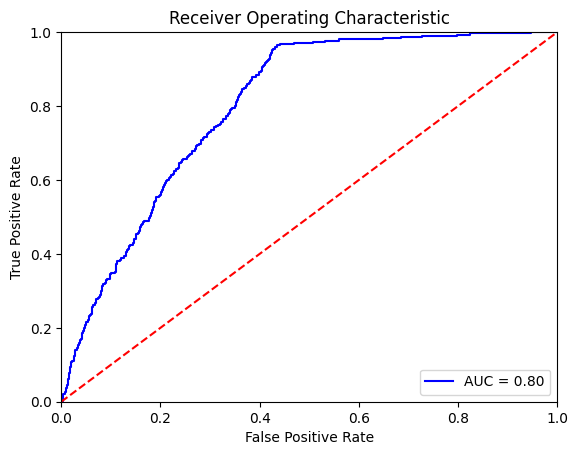

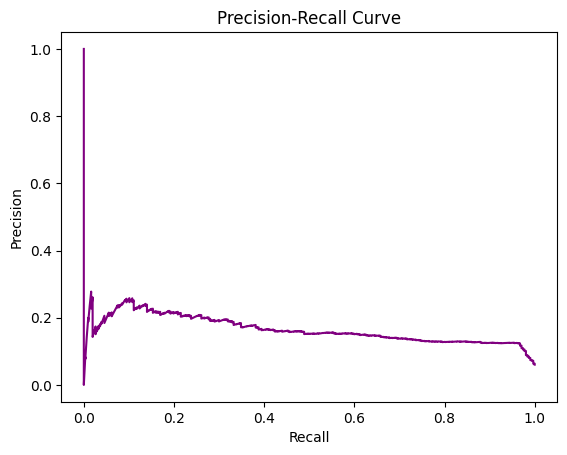

In [7]:
from sklearn.linear_model import LogisticRegression

# Vekting av klassene
svindel_prosent = float(float(100*y_train.value_counts()[1])/len(y_train))
w = {0:svindel_prosent, 1:(100-svindel_prosent)}  # Vekting av viktighet etter prosentandel representasjon i datasettet

logistic_regressor = LogisticRegression(solver='liblinear', class_weight=w)
logistic_regressor = logistic_regressor.fit(X_train, y_train)

y_pred_proba = metrikker(logistic_regressor, X_test, y_test)

## 🚀 Se på recall, precission og confusion matrix!

Etter å ha justert vektingen av viktigheten av klassene våre identifiserer vi nå de fleste svikstilfellene riktig, slik vi så at ROC-kurven og Preission Recall-kurven viste at vi kunne dersom vi gjorde den riktige trade-offen.

La oss ta en titt på modellens outputverdier, som beskriver hvordan muffensprediksjoner for påviste svindlere sammenliges med resten!

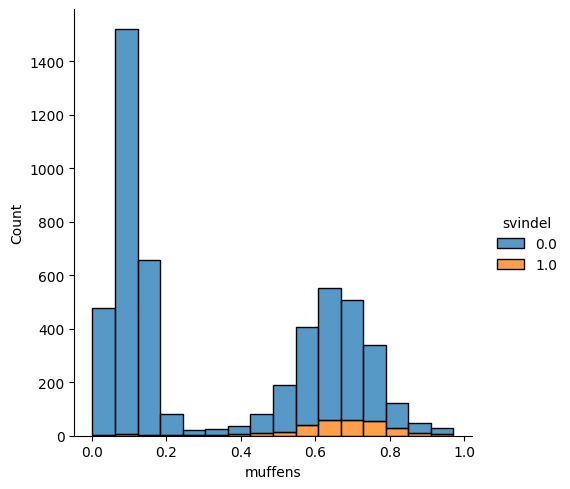

In [8]:
import seaborn as sns

combined = pd.DataFrame([y_pred_proba, y_test]).T
combined.columns = ["muffens", "svindel"]
sns.displot(data=combined, x="muffens", hue="svindel", multiple="stack")

Nå som modellen er vektet for klasseubalanse ser vi at prediksjonssansynlighetene er distribuert både over og under grensen på 0.5. 

Det er fint å se at svindlere stort sett får høy score, selv om mange som vi ikke vet at er skyldige også blir misstenkt.

## Forklarbarhet: Å titte inni den svarte boksen

Når vi så har en modell som gir prediksjoner, finnes det også verktøy for å se hvilke inputverdier som påvirker outputverdien i hver prediksjon, og for alle prediksjonene!

Her starter vi med en oppsummering av alle prediksjonene:
(Pass på! For kategoriske features som ikke er one-hot/dummy encodet er det ikke sikkert at "feature value high/low" varmekodingen inneholder så mye informasjon!)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


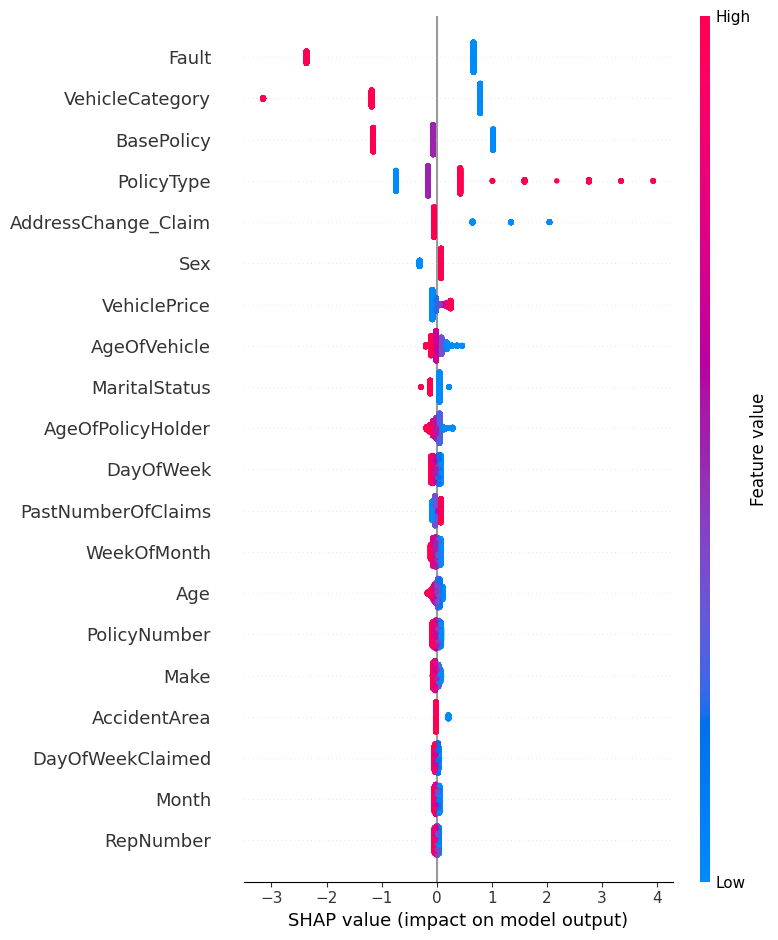

In [9]:
import sklearn
import shap

masker = shap.maskers.Independent(data=X_test)
explainer = shap.LinearExplainer(logistic_regressor, masker)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

Og her kan vi se inputverdienes påvirkning på **én enkelt prediksjon**:

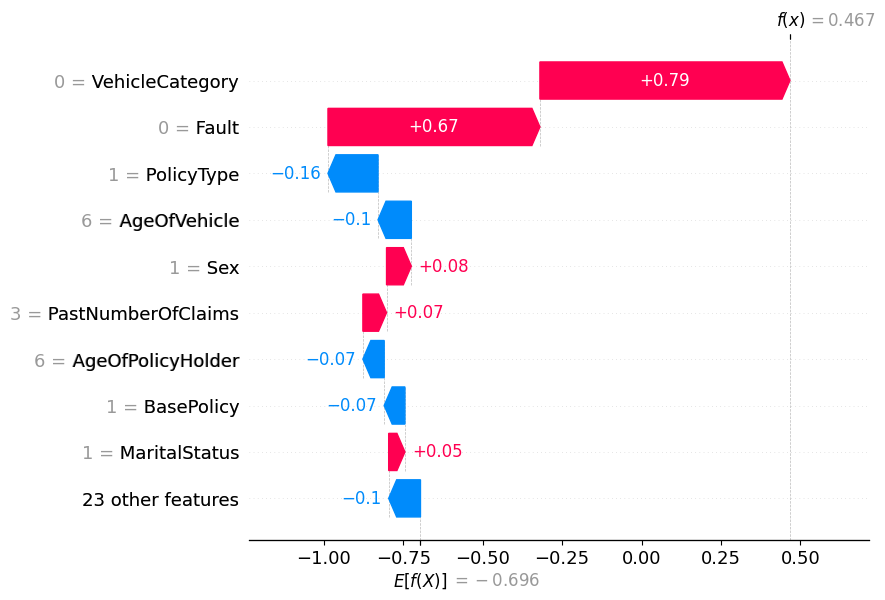

In [10]:
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])

**OBS!** Bare fordi modellen vektlegger disse faktorene slik i avgjørelsen sin, så er det ikke slik at dette er en reel sammenheng i den virkelige verden! Det kan jo være modellen din tar feil!

Det finnes mange flere spennede visualiseringsfunksjoner i SHAP-pakken. Bare å prøve seg frem hvis man har tid til overs! https://github.com/slundberg/shap

## Kryssvalidering

Nå har vi trent og testet på én splitt, men det kan være at akkurat denne splitten forårsaker unøyaktig trening eller test på grunn av arbitrære mønstre eller støy i dataen som ikke er representative for dataen som helhet. Hvis man ønsker seg et godt mål på hvor bra treningsregimet ditt og modellen din er egnet til dataen kan det lønne seg å splitte på flere forskjellige måter, og sammenligne scorene dine fra å trene og teste på forskjellige splitter.

En metode for dette kalles K-fold cross-validation. Navnet lyder slik fordi man folder dataen i K deler, og for hver av de K delene trener man først på all dataen som ikke er i delen, og så tester man på den delen. Størrelsen på K avgjør også størrelsen på test-settene, som får størrelsen 1/K. K bør være høy nok til at treningssettet inneholder et representativt utvalg av dataen i alle tilfeller, men des høyere K er des mindre representativt for populasjonen vil testfolden være.

Klassen StratifiedKFold sørger for at alle testfoldene skal ha sirka like mange svindelforsøk, og alle treningsfoldene skal ha like mange svindelforsøk.

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
 
k = 5
k_fold_x_validation = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

accuracy_cv = cross_val_score(logistic_regressor, X, y, cv=k_fold_x_validation, scoring="accuracy")
print("Avg accuracy: {}".format(round(accuracy_cv.mean(), 3)))
print(f"accuracy for alle folder: {accuracy_cv}")
roc_auc_cv = cross_val_score(logistic_regressor, X, y, cv=k_fold_x_validation, scoring="roc_auc")
print("Avg roc_auc: {}".format(round(roc_auc_cv.mean(), 3)))
print(f"roc auc for alle folder: {roc_auc_cv}")
accuracy_cv = cross_val_score(logistic_regressor, X, y, cv=k_fold_x_validation, scoring="recall")
print("Avg recall: {}".format(round(accuracy_cv.mean(), 3)))
print(f"recall for alle folder: {accuracy_cv}")

Avg accuracy: 0.61
accuracy for alle folder: [0.60927367 0.61608301 0.61478599 0.59338521 0.61413748]
Avg roc_auc: 0.79
roc auc for alle folder: [0.78334145 0.79040105 0.79191147 0.81300728 0.7707765 ]
Avg recall: 0.902
recall for alle folder: [0.86413043 0.9076087  0.92432432 0.95135135 0.86486486]


Her kan vi se at det er litt variasjon hver gang modellen trenes, fordi den konvergerer forskjellig når den trener på forskjellig data.

La oss se hvordan ROC-kurven varierer mellom forskjellige treningsfolder:

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

def cv_roc_curve(classifier, X: pd.DataFrame, y: pd.DataFrame):
    if not hasattr(classifier, "fit") and callable(classifier.fit) :
        print("Classifier needs to have method 'fit' in order for this function to make sense!")
        return
    
    cv = StratifiedKFold(n_splits=6)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X, y)):
        
        classifier.fit(X.iloc[train], y.iloc[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X.iloc[test],
            y.iloc[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Gjennomsnitlig ROC-kurve med variabilitet",
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    plt.show()

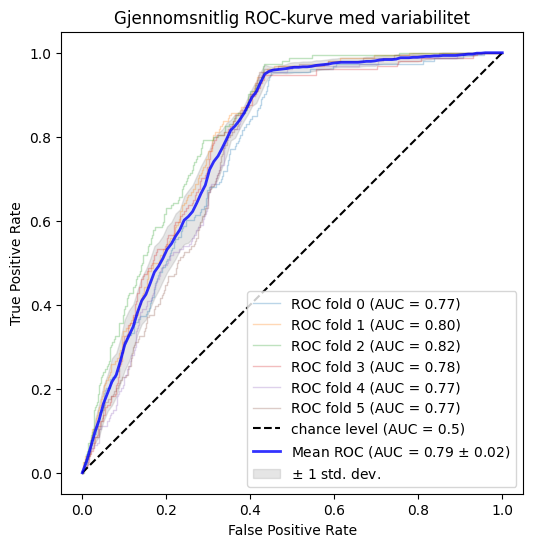

In [13]:
cv_roc_curve(logistic_regressor, X, y)

Vi ser at modellen vår er ganske robust, men har litt variasjon mellom treningsfoldene, som er naturlig. Hvis dataen er veldig stor, uniform, og uten outliers, vil det være lite variasjon mellom foldene. Hvis dataen er liten, ugjevn, og har mange outliere vil det være stor variasjon mellom foldene.

## Litt mer voksne ML-modeller

Vi håper at dere får tid til å trene én eller flere litt mer avanserte maskinlæringsmodeller i dag!

En type maskinlæringsmodell som erfaringsmessig fungerer veldig bra til å representere og utnytte tabulære data med veldig lite treningstid er **Gradient Boosted Decission Trees**. GBDT som algoritme trenger ikke one-hot encoding av kategoriske variabler for å fungere.

To populære biblioteker som leverer denne teknologien er **LightGBM**, og **XGBoost**. I Fremtind foretrekker vi LightGBM.

LightGBM sitt eget guideprosjekt (eksempelkode): https://github.com/microsoft/LightGBM/tree/master/examples/python-guide

LightGBM dokumentasjon: https://lightgbm.readthedocs.io/en/v3.3.2/ 

Det er mye man kan gjøre som maskinlæringsingeniør for å øke nøyaktigheten til en modell man trener. I tillegg til å velge data på en fornuftig måte og preprossessere den på en måte som gjør den spiselig for modellen din kan du [optimere (aka "tune") modellens hyperparametere](https://en.wikipedia.org/wiki/Hyperparameter_optimization). Når man snakker om vanlige parametere (sans "hyper") mener man det i modellen som bestemmer hvordan modellen predikerer, som trenes automatisk.Men _hyperparametere_ handler om mer generelle ting som _hvordan_ modellen trenes, og hvilke begrensninger og generell struktur modellen har. For å optimere hyperparametere pleier man å bruke kryssvalidering, som vi allerede har vist brukt på en logistisk regressor. Man kan teste en rekke kombinasjoner med hyperparametere, og velge dem som gir høy testscore. Det er mange Pythonpakkergjør dette allerede, for eksempel [Sklearn sin Grid Seach Cross Validation-klasse](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

> ***NB:*** Hvis man ukritisk tester alt for mange av kombinasjoner av hyperparametere og velger den som gir det beste resultatet vil modellens kvalitet potensielt bli dårligere en hvis man tester litt færre mulige kombinasjnoer. Kan dere tenker dere til hvorfor?

## Oppgave 1

Preprosseser dataen slik at en logistisk regresjonsmodell (som i eksempelet på begynelsen av denne notebooken) får så høy som mulig `ROC-AUC`.

### Konkurranse  

Lever preprosesserte data til preprosesseringsscoreboardet.  
Link: https://huggingface.co/spaces/marksverdhei/muffins-motor-preprocessing-scoreboard  

Preprosesseringen blir evaluert vet trening og evaluering av 
en logistiskregressjonsmodell (med default sklearn parametere),
så her lønner det seg å teste med tilsvarende modell før du leverer/laster opp

Last opp 2 filer:  

* Preprosessert datasett for trening  
* Preprosessert datasett for testing 


## Oppgave 2

Tren en hvilken som helst slags maskinlæringsmodell med så høy som mulig `ROC-AUC` score. Dere står frie til å gjøre egne valg hele veien, men får tips om at LightGBM er et godt alternativ for denne typen data.

Her har dere muligheten til å leke med hyperparameteroptimering i tillegg til datautforskningen og preprosseseringen dere gjorde i oppgave 1.

Lever prediksjonsresultatene fra deres beste maskinlæringsmodell på testsettet dere har fått utdelt.

Hvis dere ikke rekker eller greier å få til en ny maskinlæringsmodell for denne oppgaven, kan dere i værste fall levere inn resultatene fra oppgave 1 her også.

> **NB:** Korrekt måling av ROC-AUC fordrer at dere leverer inn prediksjonsdistribusjoner i form av flyttall mellom 0 og 1, og IKKE binære klassifikasjoner i form av heltall som enten er 0 eller 1.
> **TIPS**: Det er mulig å si til Sklearn at den skal bruke en spesifik score-funksjon ved trening.

> **TIPS**: Bedre forståelse av dataene og maskinlæringsmodellen dere velger vil ofte gjøre det lettere å velge gode hyperparametere, og å velge gode søkerom for hyperparameteroptimering!

### Konkurranse  

Lever prediksjonene til den beste modellen på testsettet.  
Link: https://huggingface.co/spaces/marksverdhei/muffins-motor-scoreboard  

Etter du har brukt trenings- og valideringssettet til å trene den beste modellen, 
predikerer du på `fraud_test_features.csv` og 
skriver ut en csv som inneholder sannsynlighetene for `FraudFound_P`
**NB:** CSV-en skal bare ha feltene `ID` og `FraudFound_P`, så husk å unngå å skrive indeks til fil om du ikke bruker id som indeks. 

Last op 1 fil:
* Predikerte sannsynligheter for `FraudFound_P` på test features.

## Oppgave 3

Les oppgave 3 i `README.md`!

## Bonusoppgave! 

Les bonusoppgaven i `README.md`!

In [14]:
if erstatningssak.lukter(🧁):
    erstatningssak.apply(🚩🚩🚩)

SyntaxError: invalid character '🧁' (U+1F9C1) (491833197.py, line 1)